In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [299]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
pd.set_option('mode.chained_assignment',None)
import glob
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import numpy as np

In [300]:
def split_model(df, model_name=None):
  if model_name:
    model_df = df[df.model==model_name]
  else:
    model_df = df.copy()
  td_model_df = model_df[~model_df["mode"].str.contains("baseline")]
  baseline_df = model_df[model_df["mode"].str.contains("baseline")]
  return td_model_df, baseline_df

In [301]:
def make_color_lookup(df):
  unique_tds = np.sort(td_model_df.td.unique())
  cmap = plt.cm.cool(np.linspace(0, 1, len(unique_tds)+2))[1:-1][:,:3]
  color_lookup = {key: cmap[i] for i, key in enumerate(unique_tds)}
  return color_lookup

In [302]:
def plot_figure(
    td_model_df, 
    dataset_name, 
    ylim_min=None, 
    ylim_max=None, 
    use_best=True,
    show_dist=False
  ):
  plt.figure(figsize=(8,3))
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  
  dist_model_df = td_model_df[td_model_df.distillation]
  td_model_df = td_model_df[~td_model_df.distillation]
  
  n_remove = 0
  if len(td_model_df):
    n_remove += td_model_df.td.unique().shape[0]
    model_name = td_model_df.model.iloc[0]
    color_lookup = make_color_lookup(td_model_df)
  
    # TD Model curves
    for td_key, td_df in td_model_df.groupby("td"):
      if use_best:
        asymptotic_val = td_df.val.max()
      else:
        asymptotic_val = td_df[td_df.t==td_df.t.max()].val.iloc[0]
      td_df["td"] = [
          f"TD({td_key}): {asymptotic_val:0.2f}%" 
          for td_key in td_df["td"]
      ]


      color = color_lookup[td_key]
      palette = sns.set_palette(sns.color_palette([color]))
      g = sns.lineplot(
          x="t", 
          y="val", 
          hue="td", 
          data=td_df,
          palette=palette, 
          linestyle="-",
          linewidth=2.5,
          alpha=0.5,
      )
      g2 = sns.scatterplot(
          x="t", 
          y="val", 
          hue="td",
          data=td_df,
          palette=palette, 
      )
  else:
    g = plt.gca()
    model_name = dist_model_df.model.iloc[0]

  if show_dist and len(dist_model_df):
    n_remove += 1
    if use_best:
      asymptotic_val = dist_model_df.val.max()
    else:
      asymptotic_val = dist_model_df[dist_model_df.t==dist_model_df.t.max()].val.iloc[0]
    dist_model_df["td"] = [
        f"Fast Pose CVPR 2019: {asymptotic_val:0.2f}%" 
        for td_key in dist_model_df["td"]
    ]
    color = [0.0, 0.0, 0.0]
    palette = sns.set_palette(sns.color_palette([color]))
    sns.lineplot(
        x="t",
        y="val", 
        hue="td", 
        data=dist_model_df,
        linestyle="--",
        color="black",
        linewidth=2,
        ax=g,
        alpha=0.5,
    )
    sns.scatterplot(
        x="t",
        y="val", 
        hue="td", 
        data=dist_model_df,
        color="black",
        ax=g
    )
  
  handles, labels = g.get_legend_handles_labels()
  handles = handles[:-n_remove]
  labels = labels[:-n_remove]
  leg = plt.legend(handles, labels, loc="lower right", prop={'size': 8})
  
  if show_dist and len(dist_model_df):
    leg_lines = leg.get_lines()
    leg_lines[-1].set_linestyle("--")
    
  
#   plt.suptitle(f"{model_name.capitalize()}, {dataset_name.upper()} Validation Set", fontsize=10)
#   g.set_title(f"Avg Performance over All Joints", fontsize=8)
  g.set_title(f"{model_name.capitalize()}, {dataset_name.upper()} Validation Set", fontsize=10)
  g.set_xlabel("Timestep, t")
  g.set_ylabel("Accuracy (%)")
  g.xaxis.set_major_locator(MaxNLocator(integer=True))
  
  if ylim_max:
    plt.ylim(ylim_min, ylim_max)

  plt.show()
  plt.clf()

In [303]:
DATASET_NAME = "mpii"  # mpii, coco

root = f"/hdd/mliuzzolino/CascadedPoseEstimation/results/{DATASET_NAME}"
all_result_paths = glob.glob(f"{root}/*/*")

df_dict = defaultdict(list)
for path in all_result_paths:
  result = np.load(path)
  if not result.shape:
    result = [result]
  print(path)
  basename = os.path.basename(os.path.dirname(path))
  
  split_name = basename.split("__")
  if len(split_name) == 2:
    model, td_key = split_name
    small = False
    distillation = False
    shared_weights = False
  else:
    model, td_key = split_name[:2]
    small = "small" in basename
    distillation = "distillation" in basename
    shared_weights = "shared_weights" in basename
    
  td_key = float(td_key.split("_")[1])
  n_stacks = int(model.split("_x")[1])
  model = model.replace("_", " ")

  for t, val in enumerate(result):
    df_dict["model"].append(model)
    df_dict["n_stacks"].append(n_stacks)
    df_dict["shared_weights"].append(shared_weights)
    df_dict["t"].append(t)
    df_dict["td"].append(td_key)
    df_dict["small"].append(small)
    df_dict["distillation"].append(distillation)
    df_dict["val"].append(val)
df_src = pd.DataFrame(df_dict)
df_src = df_src[df_src.n_stacks>1]
# df_src = df_src[df_src.n_stacks==4]
small_df = df_src[df_src.small==True]
df = df_src[df_src.small==False]

/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x4__TD_1.0/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x4__TD_1.0__distillation/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x8__TD_0.9/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x8__TD_0.0/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x4__TD_1.0__shared_weights/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x8__TD_1.0/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x4__TD_0.5/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x1__TD_1.0/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x4__TD_0.9/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x4__TD_0.0/result__0.5.npy
/hdd/mliuzzolino/CascadedPoseEstimation/results/mpii/hourglass_x4__TD_

In [304]:
target_val_td09 = df[((df.n_stacks==8) & (df.td==0.9) & (df.t==5))].val.iloc[0]
target_val_td1 = df[((df.n_stacks==8) & (df.td==1.0) & (df.t==5))].val.iloc[0]
target_val_td09, target_val_td1

(89.79546964758299, 90.39345405057084)

In [305]:
# Hacky
df.loc[((df.n_stacks==8) & (df.td==1.0) & (df.t==6)), "val"] = target_val_td1
df.loc[((df.n_stacks==8) & (df.td==1.0) & (df.t==7)), "val"] = target_val_td1

df.loc[((df.n_stacks==8) & (df.td==0.9) & (df.t==6)), "val"] = target_val_td09
df.loc[((df.n_stacks==8) & (df.td==0.9) & (df.t==7)), "val"] = target_val_td09

In [309]:
shared_weights_df = df[df.shared_weights]
untied_weights_df = df[~df.shared_weights]

In [312]:
plot_df = shared_weights_df

<Figure size 640x480 with 0 Axes>

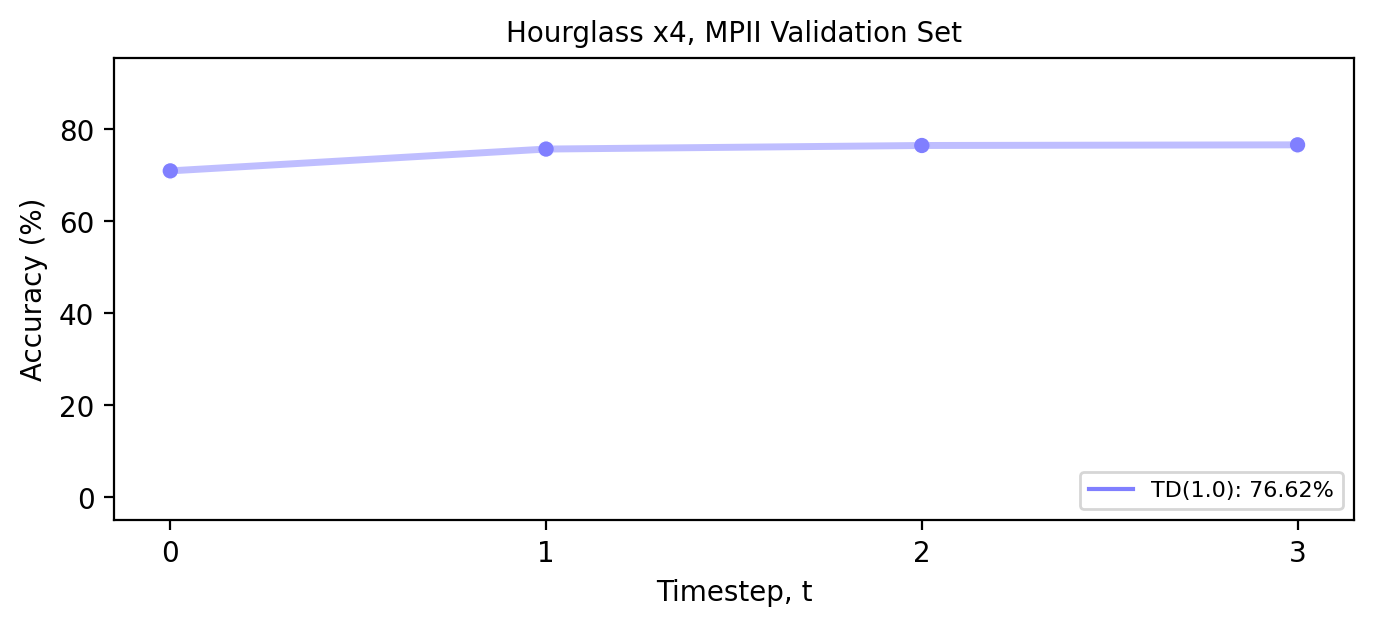

In [313]:
ylim_max = float(df.val.max())
ylim_max += 5
SHOW_DIST = True
for model_key, td_model_df in plot_df.groupby("model"):
  plot_figure(
      td_model_df, 
      dataset_name=DATASET_NAME, 
      ylim_min=df.val.min() - 5,
      ylim_max=ylim_max,
      show_dist=SHOW_DIST
  )

<Figure size 640x480 with 0 Axes>

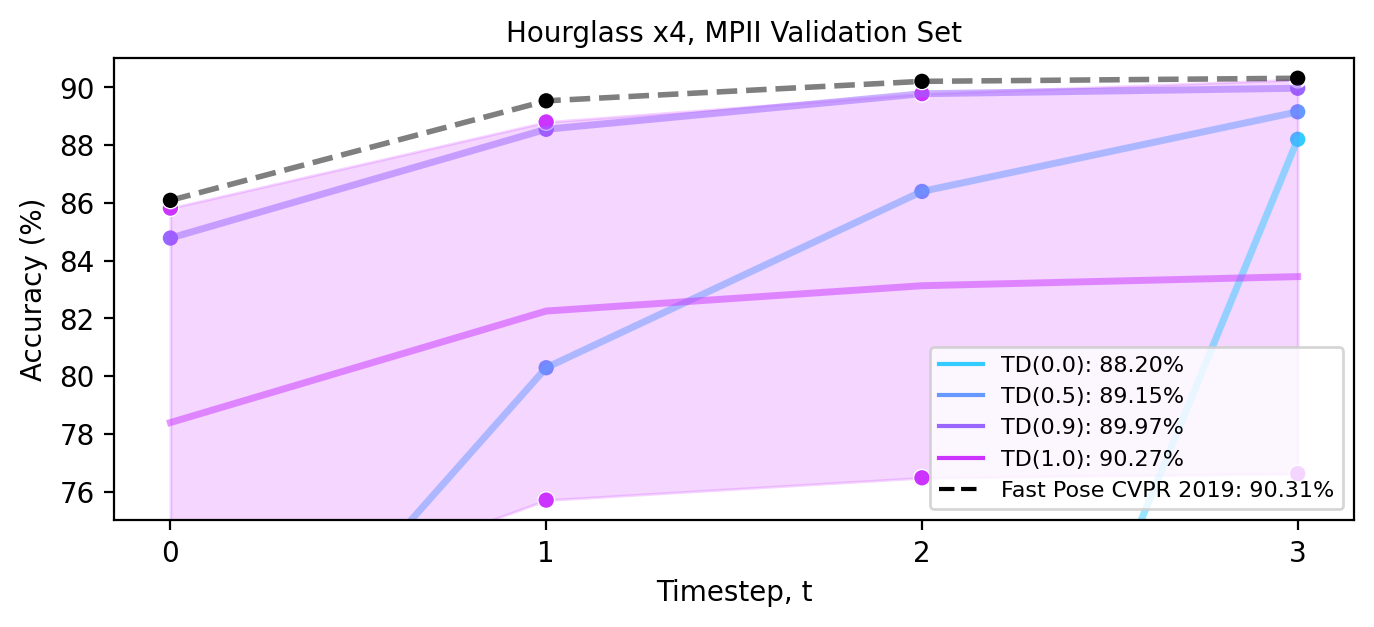

<Figure size 640x480 with 0 Axes>

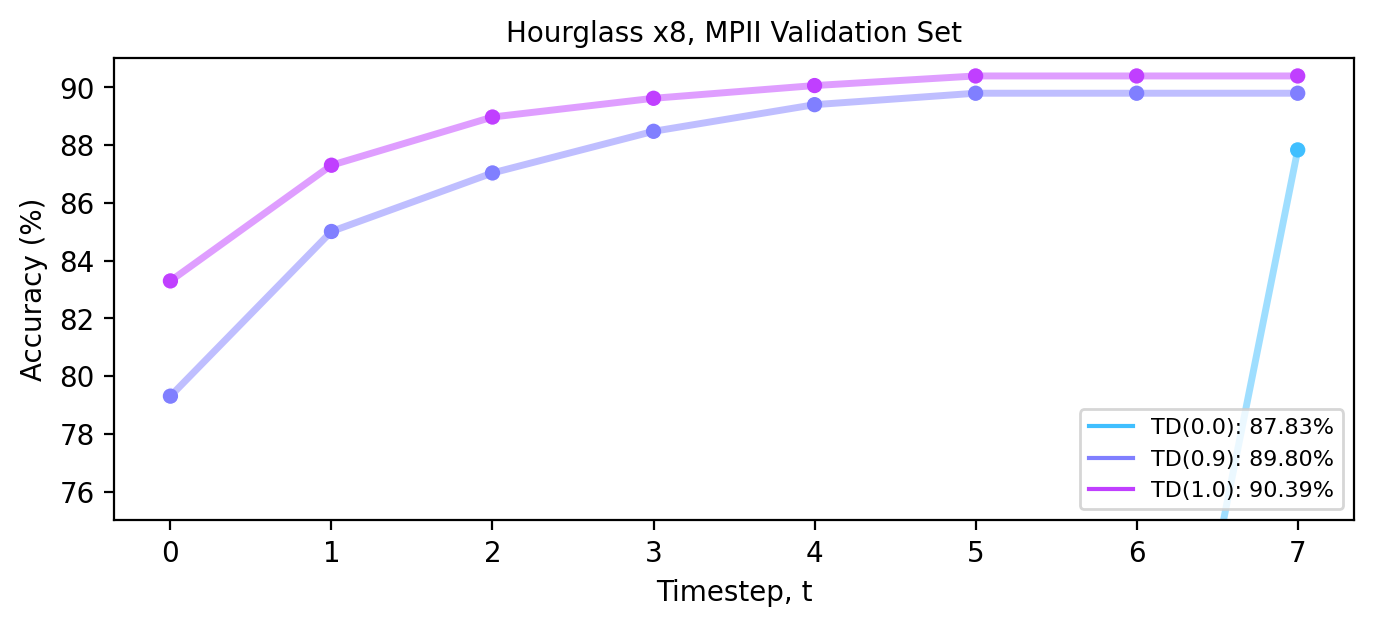

In [307]:
ylim_max = float(df.val.max())
ylim_max += 5
SHOW_DIST = True
for model_key, td_model_df in df.groupby("model"):
  plot_figure(
      td_model_df, 
      dataset_name=DATASET_NAME, 
      ylim_min=75,
      ylim_max=91,
      show_dist=SHOW_DIST
  )

In [ ]:
plt.figure(figsize=(4,4))
td1_df = df[df.td==1.0]
td1_df = td1_df[td1_df.n_stacks > 1]
n_stacks = td1_df.n_stacks.unique().shape[0]
colors = plt.cm.cool(np.linspace(0, 1, n_stacks))
for i, (n_stacks, stack_df) in enumerate(td1_df.groupby("n_stacks")):
  color = colors[i]
  g = sns.scatterplot(x="n_stacks", y="val", data=stack_df, color=color)
g.set(xlabel="# Stacks", ylabel="Accuracy (%)")
# g.set_ylim(74, 91)
g.xaxis.set_major_locator(MaxNLocator(integer=True))
g.set_xticks(np.sort(td1_df.n_stacks.unique()))
plt.show()

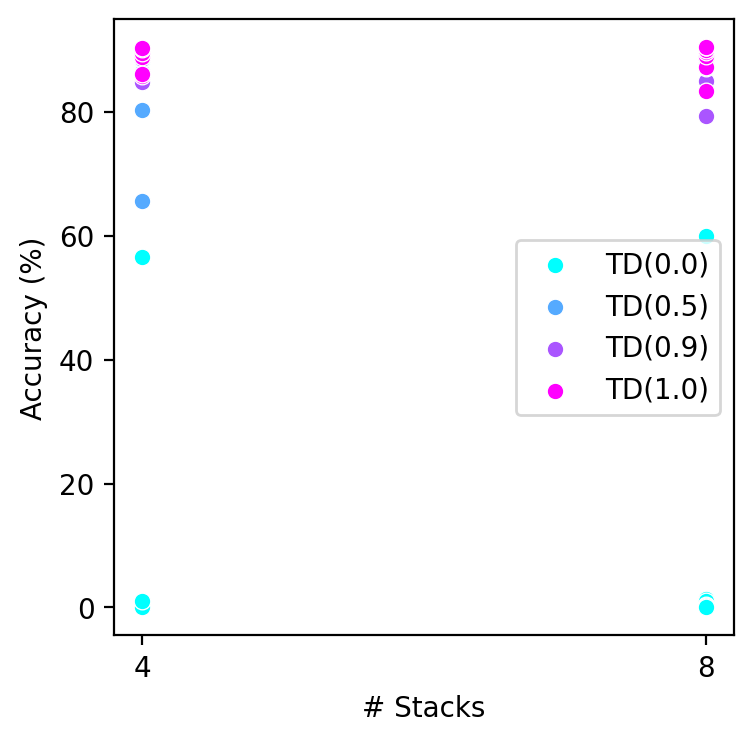

In [265]:
plt.figure(figsize=(4,4))
n_tds = df.td.unique().shape[0]
colors = plt.cm.cool(np.linspace(0, 1, n_tds))
for i, (td_key, td_df) in enumerate(df.groupby("td")):
  color = colors[i]
  label = f"TD({td_key})"
  g = sns.scatterplot(x="n_stacks", y="val", data=td_df, color=color, label=label)
g.set(xlabel="# Stacks", ylabel="Accuracy (%)")
# g.set_ylim(0, 91)
g.xaxis.set_major_locator(MaxNLocator(integer=True))
g.set_xticks(np.sort(df.n_stacks.unique()))
plt.show()

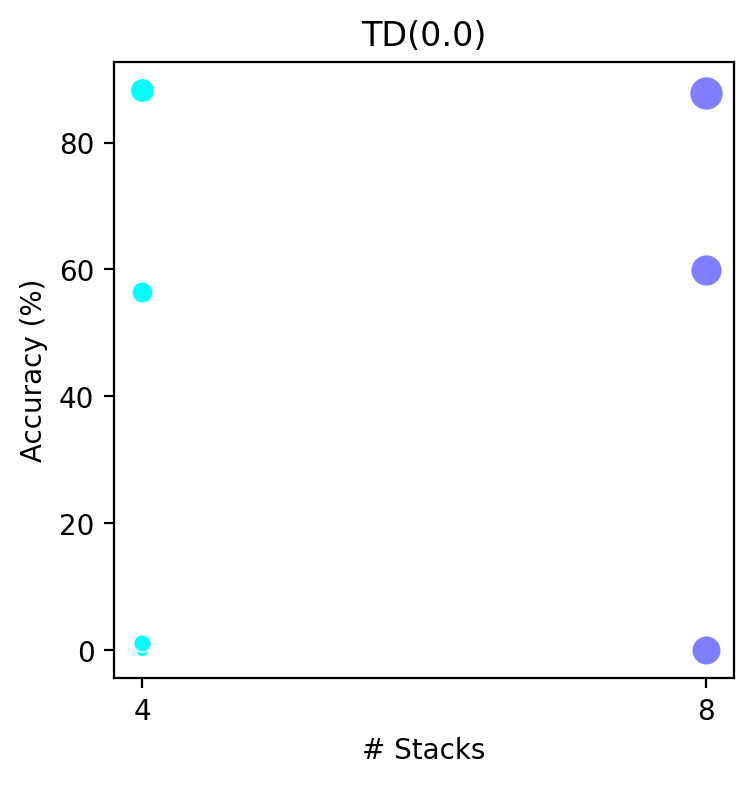

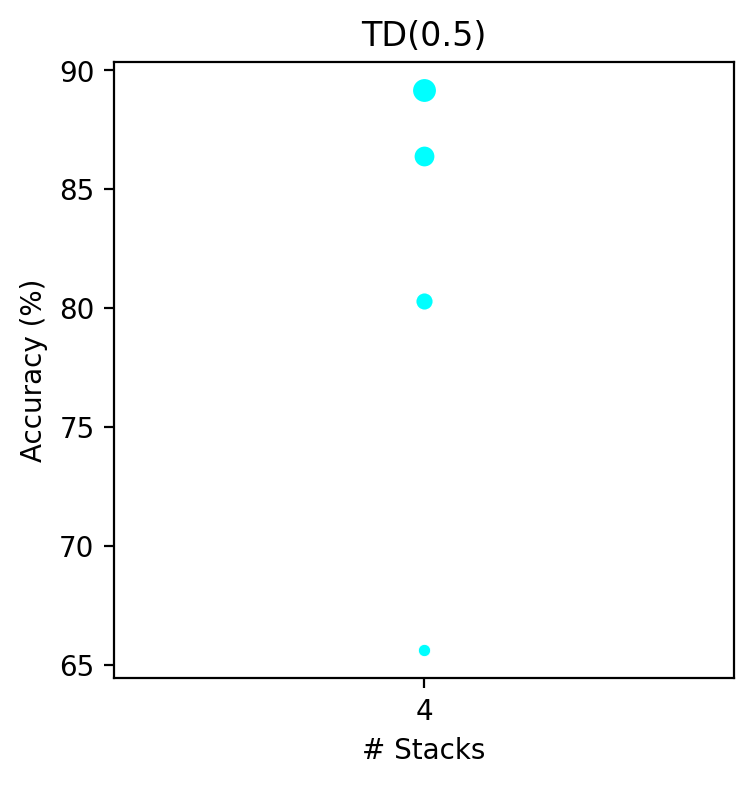

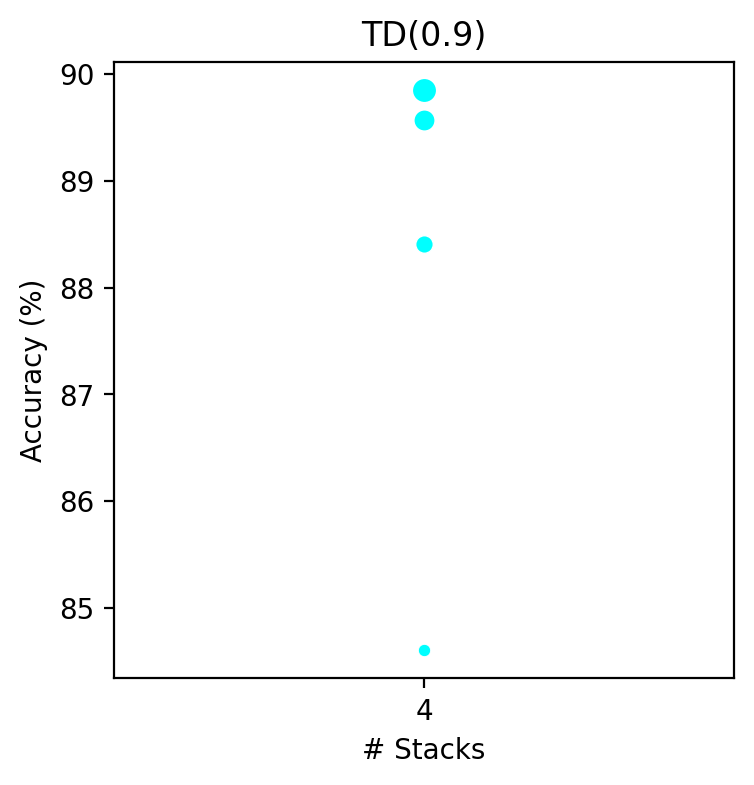

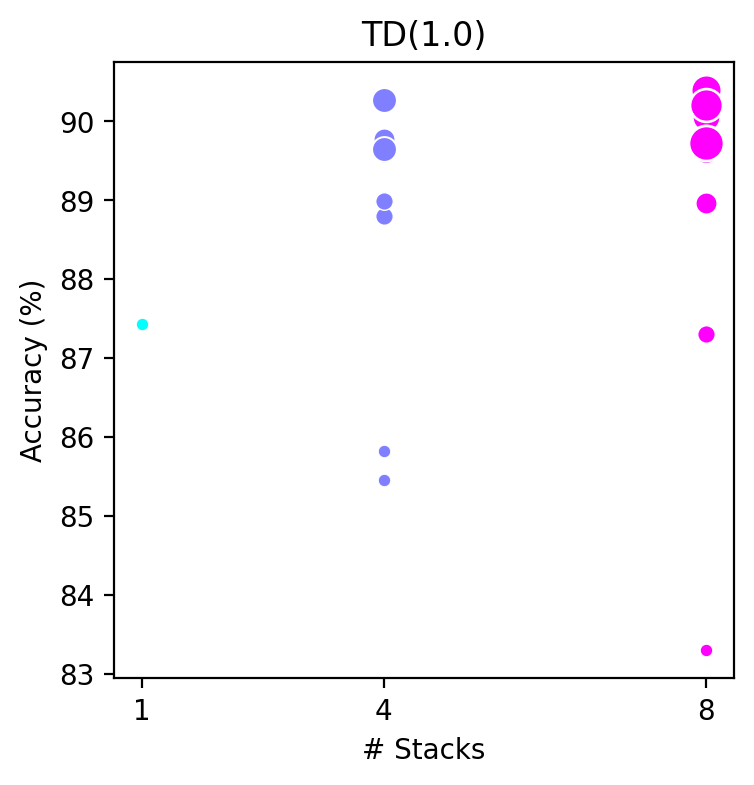

In [72]:
n_unique_stacks = df.n_stacks.unique().shape[0]
colors = plt.cm.cool(np.linspace(0, 1, n_unique_stacks))
for td_key, td_df in df.groupby("td"):
  plt.figure(figsize=(4,4))
  ax = plt.gca()
  for i, (n_stack, stack_df) in enumerate(td_df.groupby("n_stacks")):
    color = colors[i]
    title = f"TD({td_key})"
    for t, t_df in stack_df.groupby("t"):
      size = 20 * (t + 1)
      g = sns.scatterplot(
          x="n_stacks", 
          y="val", 
          data=t_df, 
          color=color, 
          s=size, 
          ax=ax
      )
    g.set(xlabel="# Stacks", ylabel="Accuracy (%)", title=title)
    g.xaxis.set_major_locator(MaxNLocator(integer=True))
    g.set_xticks(np.sort(td_df.n_stacks.unique()))
  plt.show()

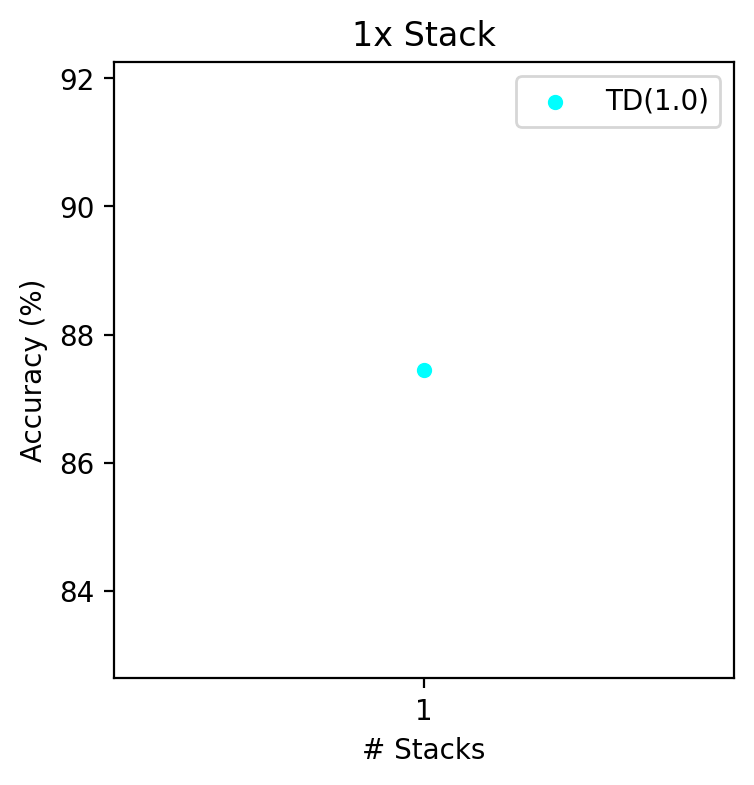

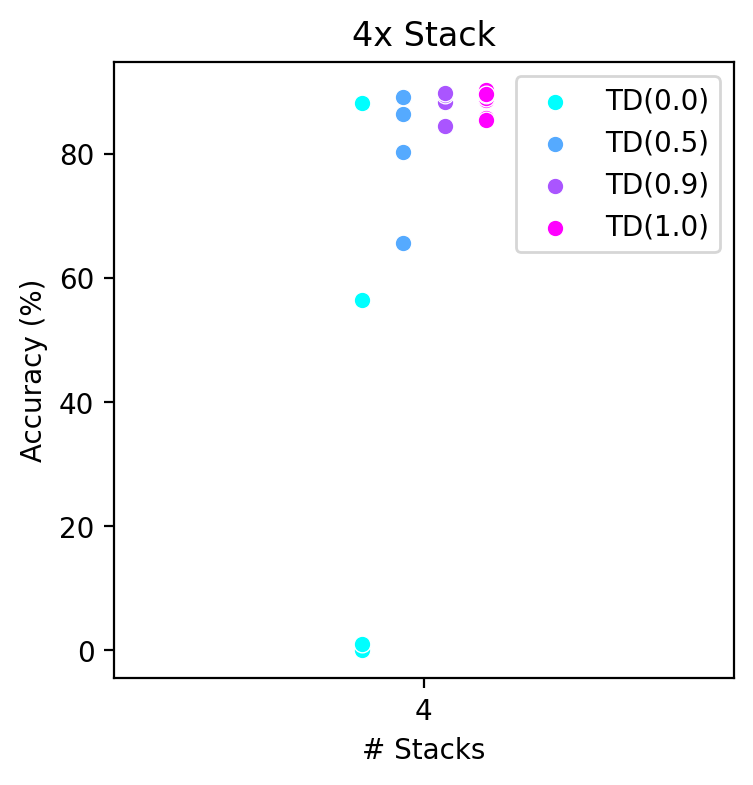

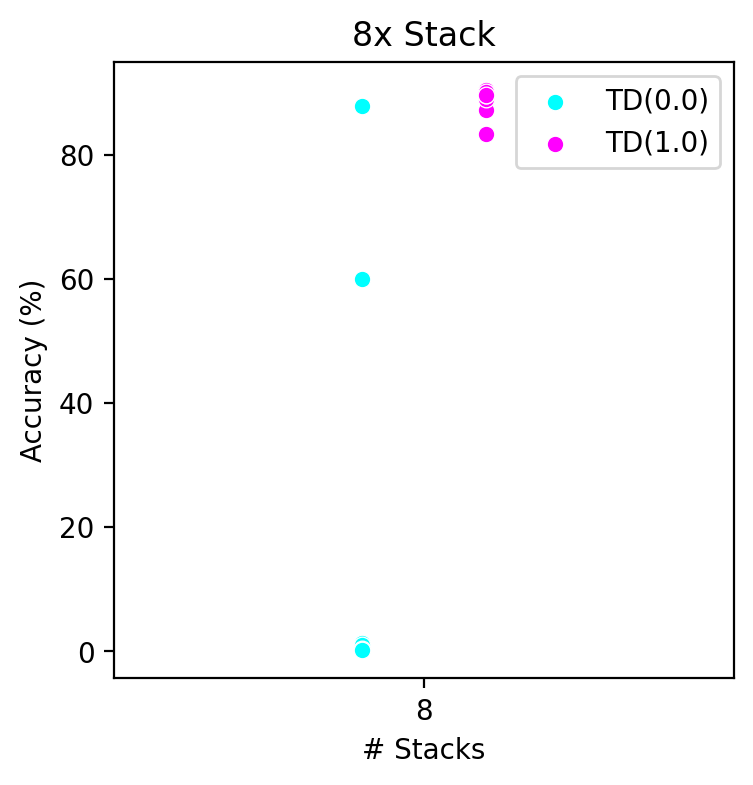

In [73]:
for stack_key, stack_df in df.groupby("n_stacks"):
  title = f"{stack_key}x Stack"
  plt.figure(figsize=(4,4))
  
  n_tds = stack_df.td.unique().shape[0]
  colors = plt.cm.cool(np.linspace(0, 1, n_tds))
  if n_tds > 1:
    offsets = np.linspace(0, 1, n_tds) - 0.5
    offsets = offsets * 0.2
    offsets = offsets[::-1]
  else:
    offsets = [0]
  for i, (td_key, td_df) in enumerate(stack_df.groupby("td")):
    color = colors[i]
    offset = offsets[i]
    td_df = td_df.copy()
    td_df.n_stacks = [ele - offset for ele in td_df.n_stacks]
    
    g = sns.scatterplot(
        x="n_stacks", 
        y="val", 
        data=td_df, 
        color=color, 
        label=f"TD({td_key})"
    )
  g.set(xlabel="# Stacks", ylabel="Accuracy (%)", title=title)
  
  g.set_xlim(stack_key-0.5, stack_key+0.5)
  g.xaxis.set_major_locator(MaxNLocator(integer=True))
  g.set_xticks(np.sort(stack_df.n_stacks.unique()))
  plt.show()

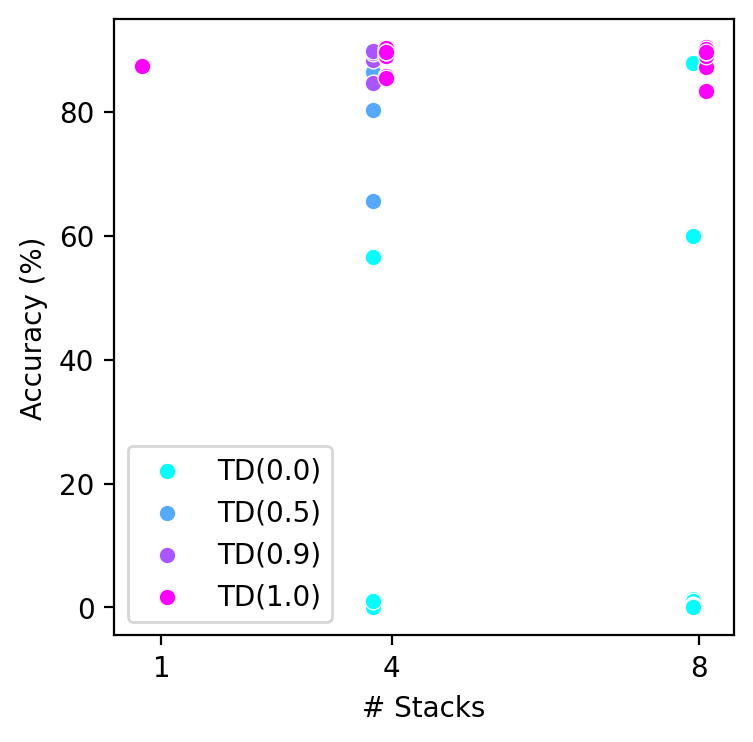

In [74]:
plt.figure(figsize=(4,4))
n_tds = df.td.unique().shape[0]
colors = plt.cm.cool(np.linspace(0, 1, n_tds))
for i, (td_key, td_df) in enumerate(df.groupby("td")):
  color = colors[i]
  label = f"TD({td_key})"
  
  if n_tds > 1:
    offsets = np.linspace(0, 1, n_tds) - 0.5
    offsets = offsets * 0.5
    offsets = offsets[::-1]
  else:
    offsets = [0]
    
  for i, (n_stack, stack_df) in enumerate(td_df.groupby("n_stacks")):
    offset = offsets[i]
    stack_df = stack_df.copy()
    stack_df.n_stacks = [ele - offset for ele in stack_df.n_stacks]
    label = label if i == 0 else None
    g = sns.scatterplot(x="n_stacks", y="val", data=stack_df, color=color, label=label)
g.set(xlabel="# Stacks", ylabel="Accuracy (%)")
# g.set_ylim(0, 91)
g.xaxis.set_major_locator(MaxNLocator(integer=True))
g.set_xticks(np.sort(df.n_stacks.unique()))
plt.show()